## Intro to EDA with Time Series 

> This notebook is a modified version of a notebook from the Berlin Time Series Meetup by Juan Orduz. If you want to dive deeper into time series we can highly reccomend to check out the repository of the meetup on [github](https://github.com/juanitorduz/btsa).

Time series forcasting is another interesting aspect of Data Science. In this notebook we will have a look at some simple plots and methods you can apply when you start with a time series project. We will show on a simple example how to manipulate and plot time series data in python.

#### At the end of this notebook you should:
 * know some helpful plots to start with your time series data
 * know how to decompose a time series and what the single components are

## Setup

All the manipulations and plots in this notebook can be created with standard libraries such as matplotlib, statsmodels etc. 

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
sns_c

[(0.09803921568627451, 0.19607843137254902, 0.3176470588235294),
 (1.0, 0.35294117647058826, 0.21176470588235294),
 (0.4117647058823529, 0.4117647058823529, 0.4117647058823529),
 (0.4588235294117647, 0.5372549019607843, 0.6352941176470588),
 (1.0, 0.35294117647058826, 0.21176470588235294),
 (0.8588235294117647, 0.4, 0.40784313725490196)]

## Import Data 

The data for this notebook was downloaded from the [meteoblue website](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604) and consits of weather data for the city of Basel from 2008 till 2020. 

In [ ]:
files = [
    "data/EP_2024/GUI_ENERGY_PRICES_202412312300-202512312300_UTC.csv",
   # "data/EP_2024/GUI_ENERGY_PRICES_202512312300-202512312300_UTC.csv",
]
raw_df_price = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)


In [68]:
# Create working copy of dataframe
df_price = raw_df_price.copy()
# select only those values
#data_df = data_df[data_df["Sequence"] == "Sequence Sequence 1"]
 # drop columns
df_price.drop(columns=["Area","Sequence","MTU (CET/CEST) Start","MTU (CET/CEST) End","SummerIndicator"], inplace=True)
# Rename columns in a more pythonic way
df_price = df_price.rename(columns={
    'MTU (CET/CEST) End UTC': 'timestamp',
    'Day-ahead Price (EUR/MWh)' : 'Price'
    }
)

df_price = df_price.assign(
    timestamp=lambda x: pd.to_datetime(
        x["timestamp"],
        format="mixed",
        dayfirst=True,
        errors="coerce"
    ),
    date=lambda x: x["timestamp"].dt.date,
    year=lambda x: x["timestamp"].dt.year,
    month=lambda x: x["timestamp"].dt.month,
    monthname=lambda x: x["timestamp"].dt.month_name(),
    day=lambda x: x["timestamp"].dt.day,
    dayofyear=lambda x: x["timestamp"].dt.dayofyear,
    hour=lambda x: x["timestamp"].dt.hour,
    #week=lambda x: x["timestamp"].dt.isocalendar().week.astype(int),
    week=lambda x: x["timestamp"].dt.isocalendar().week.astype("Int64"),
    dayofweek=lambda x: x["timestamp"].dt.dayofweek,   # 0=Mon ... 6=Sun
    dayname=lambda x: x["timestamp"].dt.day_name(),   
)

df_price.head()


,MTU (CET/CEST),Price,timestamp,date,year,month,monthname,day,dayofyear,hour,week,dayofweek,dayname
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,2.16,2024-12-31 23:15:00,2024-12-31,2024,12,December,31,366,23,1,1,Tuesday
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,2.16,2024-12-31 23:30:00,2024-12-31,2024,12,December,31,366,23,1,1,Tuesday
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,2.16,2024-12-31 23:45:00,2024-12-31,2024,12,December,31,366,23,1,1,Tuesday
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,2.16,2025-01-01 00:00:00,2025-01-01,2025,1,January,1,1,0,1,2,Wednesday
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,1.60,2025-01-01 00:15:00,2025-01-01,2025,1,January,1,1,0,1,2,Wednesday


In [36]:
files = [
    "data/EP_2024/GUI_TOTAL_GENERATION_FORECAST_202412312300-202512312300.csv",
]
raw_df_gen_forecast = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)

In [43]:
raw_df_gen_forecast.columns

Index(['MTU (CET/CEST)', 'Area', 'Generation Forecast (MW)',
       'Actual Generation (MW)', 'Scheduled Consumption (MW)'],
      dtype='object')

In [88]:
df_gen_forecast = raw_df_gen_forecast[["MTU (CET/CEST)", "Generation Forecast (MW)", "Actual Generation (MW)"]]
# .rename(
#     columns={
#         "Generation Forecast (MW)": "GenForcast",
#         "Actual Generation (MW)": "ActualGen"
#     }
# )
df_gen_forecast.head()

,MTU (CET/CEST),Generation Forecast (MW),Actual Generation (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,56958.77,54364.42
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,56351.59,54352.05
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,56269.29,53669.64
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,56507.27,53384.97
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,56223.26,54173.60


In [37]:
files = [
    "data/EP_2024/GUI_WIND_SOLAR_GENERATION_FORECAST_OFFSHORE_202412312300-202512312300.csv",
]
raw_df_res_offshore = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)

In [58]:
raw_df_res_offshore.columns

Index(['MTU (CET/CEST)', 'Area', 'Day-ahead (MW)', 'Intraday (MW)',
       'Current (MW)', 'Actual (MW)'],
      dtype='object')

In [87]:
df_res_offshore = raw_df_res_offshore[["MTU (CET/CEST)", "Day-ahead (MW)", "Intraday (MW)","Current (MW)","Actual (MW)"]].rename(
    columns={
        "Day-ahead (MW)": "OffSh Day-ahead (MW)",
        "Intraday (MW)": "OffSh Intraday (MW)",
        "Current (MW)": "OffSh Current (MW)",
        "Actual (MW)": "OffSh Actual (MW)",
    }
)
df_res_offshore.head()

,MTU (CET/CEST),OffSh Day-ahead (MW),OffSh Intraday (MW),OffSh Current (MW),OffSh Actual (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,3742.06,2640.59,2640.59,2415.09
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,3756.45,2625.86,2625.86,2601.31
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,3763.86,2598.45,2598.45,2542.27
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,3776.26,3452.40,3452.40,2450.01
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,3784.38,3356.40,3356.40,2252.60


In [38]:
files = [
    "data/EP_2024/GUI_WIND_SOLAR_GENERATION_FORECAST_ONSHORE_202412312300-202512312300.csv",
]
raw_df_res_onshore = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)

In [48]:
raw_df_res_onshore.columns

Index(['MTU (CET/CEST)', 'Area', 'Day-ahead (MW)', 'Intraday (MW)',
       'Current (MW)', 'Actual (MW)'],
      dtype='object')

In [86]:
df_res_onshore = raw_df_res_onshore[["MTU (CET/CEST)", "Day-ahead (MW)", "Intraday (MW)","Current (MW)","Actual (MW)"]].rename(
    columns={
        "Day-ahead (MW)": "OnSh Day-ahead (MW)",
        "Intraday (MW)": "OnSh Intraday (MW)",
        "Current (MW)": "OnSh Current (MW)",
        "Actual (MW)": "OnSh Actual (MW)",
    }
)
df_res_onshore.head()

,MTU (CET/CEST),OnSh Day-ahead (MW),OnSh Intraday (MW),OnSh Current (MW),OnSh Actual (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,38289.70,35381.95,35381.95,32973.68
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,38511.97,35505.27,35505.27,32832.53
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,38706.47,35567.34,35567.34,32832.18
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,38869.75,35671.53,35671.53,32895.95
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,38917.29,35707.66,35707.66,33260.24


In [39]:
files = [
    "data/EP_2024/GUI_WIND_SOLAR_GENERATION_FORECAST_SOLAR_202412312300-202512312300.csv",
]
raw_df_res_solar = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)

In [53]:
raw_df_res_solar.columns

Index(['MTU (CET/CEST)', 'Area', 'Day-ahead (MW)', 'Intraday (MW)',
       'Current (MW)', 'Actual (MW)'],
      dtype='object')

In [56]:
df_res_solar = raw_df_res_solar[["MTU (CET/CEST)", "Day-ahead (MW)", "Intraday (MW)","Current (MW)","Actual (MW)"]].rename(
    columns={
        "Day-ahead (MW)": "solar Day-ahead (MW)",
        "Intraday (MW)": "solar Intraday (MW)",
        "Current (MW)": "solar Current (MW)",
        "Actual (MW)": "solar Actual (MW)",
    }
)

In [57]:
df_res_solar.head()

,MTU (CET/CEST),solar Day-ahead (MW),solar Intraday (MW),solar Current (MW),solar Actual (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,0.0,0.0,0.0,9.97
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,0.0,0.0,0.0,9.32
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,0.0,0.0,0.0,9.37
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,0.0,0.0,0.0,9.56
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,0.0,0.0,0.0,9.93


In [ ]:
### 
### Keys need to be changed!!!!
###

files = [
    "data/EP_2024/GUI_TOTAL_LOAD_DAYAHEAD_202412312300-202512312300.csv",
]
raw_df_load = pd.concat((pd.read_csv(f, delimiter=",") for f in files), ignore_index=True)

In [64]:
df_price.shape

(35040, 12)

In [67]:
df_price.columns

Index(['Price', 'timestamp', 'date', 'year', 'month', 'monthname', 'day',
       'dayofyear', 'hour', 'week', 'dayofweek', 'dayname'],
      dtype='object')

In [ ]:
from functools import reduce

dfs = [df_price, df_gen_forecast, df_res_offshore, df_res_onshore, df_res_solar]
# dfs = [
#     raw_df,
#     raw_df_res_offshore, #[["MTU (CET/CEST)", "Day-ahead (MW)","Intraday (MW)","Current (MW)","Actual (MW)"]],
# ]

data_df = reduce(
    lambda left, right: pd.merge(left, right, on="MTU (CET/CEST)", how="outer"),
    dfs
)

In [84]:
data_df.shape

(35040, 27)

In [85]:
data_df.head(9)

,MTU (CET/CEST),Price,timestamp,date,year,month,monthname,day,dayofyear,hour,...,OffSh Current (MW),OffSh Actual (MW),OnSh Day-ahead (MW),OnSh Intraday (MW),OnSh Current (MW),OnSh Actual (MW),solar Day-ahead (MW),solar Intraday (MW),solar Current (MW),solar Actual (MW)
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,2.16,2024-12-31 23:15:00,2024-12-31,2024,12,December,31,366,23,...,2640.59,2415.09,38289.70,35381.95,35381.95,32973.68,0.0,0.0,0.0,9.97
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,2.16,2024-12-31 23:30:00,2024-12-31,2024,12,December,31,366,23,...,2625.86,2601.31,38511.97,35505.27,35505.27,32832.53,0.0,0.0,0.0,9.32
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,2.16,2024-12-31 23:45:00,2024-12-31,2024,12,December,31,366,23,...,2598.45,2542.27,38706.47,35567.34,35567.34,32832.18,0.0,0.0,0.0,9.37
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,2.16,2025-01-01 00:00:00,2025-01-01,2025,1,January,1,1,0,...,3452.40,2450.01,38869.75,35671.53,35671.53,32895.95,0.0,0.0,0.0,9.56
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,1.60,2025-01-01 00:15:00,2025-01-01,2025,1,January,1,1,0,...,3356.40,2252.60,38917.29,35707.66,35707.66,33260.24,0.0,0.0,0.0,9.93
5,01/01/2025 01:15:00 - 01/01/2025 01:30:00,1.60,2025-01-01 00:30:00,2025-01-01,2025,1,January,1,1,0,...,3413.66,2509.98,38983.06,36049.78,36049.78,33493.71,0.0,0.0,0.0,9.91
6,01/01/2025 01:30:00 - 01/01/2025 01:45:00,1.60,2025-01-01 00:45:00,2025-01-01,2025,1,January,1,1,0,...,3452.99,2410.54,39093.74,36158.65,36158.65,33644.01,0.0,0.0,0.0,9.07
7,01/01/2025 01:45:00 - 01/01/2025 02:00:00,1.60,2025-01-01 01:00:00,2025-01-01,2025,1,January,1,1,1,...,3339.43,2407.95,39230.54,36467.21,36467.21,33717.47,0.0,0.0,0.0,9.27
8,01/01/2025 02:00:00 - 01/01/2025 02:15:00,0.00,2025-01-01 01:15:00,2025-01-01,2025,1,January,1,1,1,...,3297.63,2676.36,39366.94,36753.38,36753.38,33789.14,0.0,0.0,0.0,9.34


In [92]:
data_df.columns

Index(['MTU (CET/CEST)', 'Price', 'timestamp', 'date', 'year', 'month',
       'monthname', 'day', 'dayofyear', 'hour', 'week', 'dayofweek', 'dayname',
       'Generation Forecast (MW)', 'Actual Generation (MW)',
       'OffSh Day-ahead (MW)', 'OffSh Intraday (MW)', 'OffSh Current (MW)',
       'OffSh Actual (MW)', 'OnSh Day-ahead (MW)', 'OnSh Intraday (MW)',
       'OnSh Current (MW)', 'OnSh Actual (MW)', 'solar Day-ahead (MW)',
       'solar Intraday (MW)', 'solar Current (MW)', 'solar Actual (MW)'],
      dtype='object')

## Visualize the Data

Let us start by plotting the temperature data over time. We can either use the hourly development or aggregate the feature by day to get a less dense plot. 

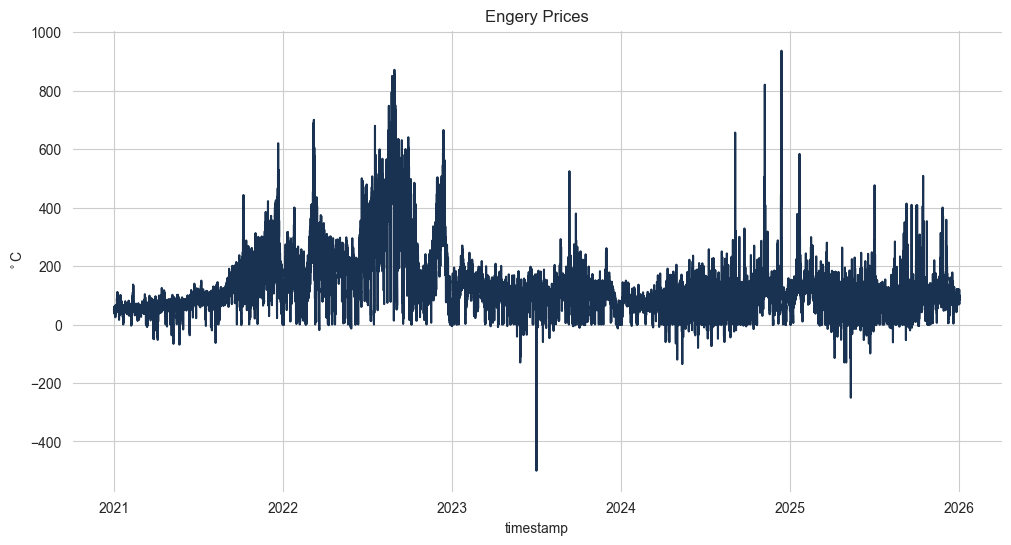

In [20]:
# Temperature hourly development over time 
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='Price', data=data_df, ax=ax)
ax.set(title='Engery Prices', ylabel=r'$^\circ$C');

fig.savefig("visualisations/Energy_Prices.png",dpi=300)

In [21]:
# Aggregate temperature by day
daily_data_df = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'Price': np.mean}) \
    .set_index('date')

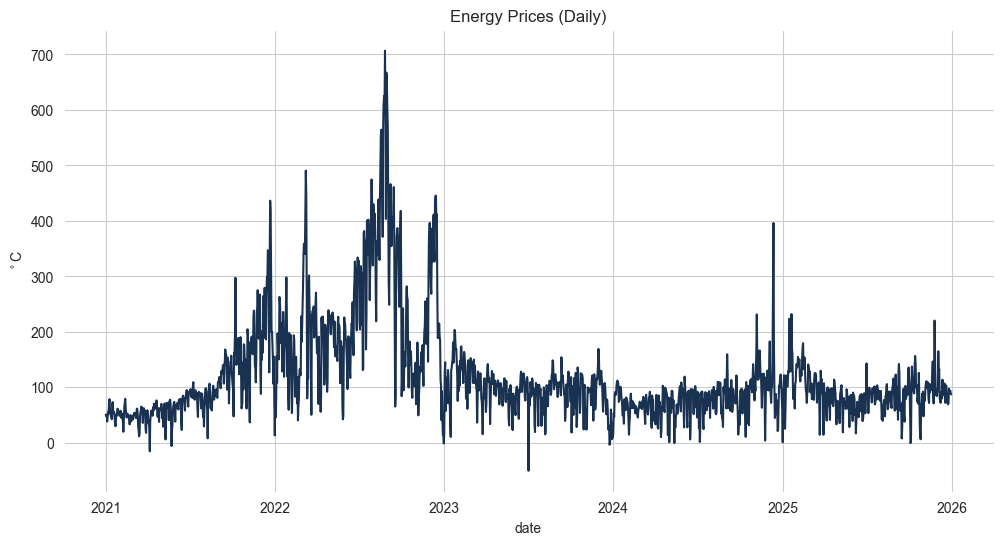

In [22]:
# Plot temperature on daily basis 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='Price', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Energy Prices (Daily)', ylabel=r'$^\circ$C');

fig.savefig("visualisations/Energy_Prices_daily.png",dpi=300)